In [1]:
import torch

from datetime import datetime
from torch.utils.tensorboard.writer import SummaryWriter
from reference_models.heidenreich.vae import VAE
from tqdm import tqdm
from torchvision import datasets
from torchvision.transforms import v2


batch_size = 128
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Lambda(lambda x: x.view(-1) - 0.5),
    ]
)

# Download and load the training data
train_data = datasets.MNIST(
    "~/.pytorch/MNIST_data/",
    download=True,
    train=True,
    transform=transform,
)
# Download and load the test data
test_data = datasets.MNIST(
    "~/.pytorch/MNIST_data/",
    download=True,
    train=False,
    transform=transform,
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
)

In [2]:
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [3]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode

    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)

        optimizer.zero_grad()  # Zero the gradients

        output = model(data)  # Forward pass
        loss = output.loss

        loss.backward()

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1.0 / 2)

            print(
                f"Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}"
            )

            if writer is not None:
                global_step = n_upd
                writer.add_scalar("Loss/Train", loss.item(), global_step)
                writer.add_scalar(
                    "Loss/Train/BCE", output.loss_recon.item(), global_step
                )
                writer.add_scalar("Loss/Train/KLD", output.loss_kl.item(), global_step)
                writer.add_scalar("GradNorm/Train", total_norm, global_step)

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)


def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data, target in tqdm(dataloader, desc="Testing"):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(
        f"====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})"
    )

    if writer is not None:
        writer.add_scalar("Loss/Test", test_loss, global_step=cur_step)
        writer.add_scalar(
            "Loss/Test/BCE", output.loss_recon.item(), global_step=cur_step
        )
        writer.add_scalar("Loss/Test/KLD", output.loss_kl.item(), global_step=cur_step)

        # Log reconstructions
        writer.add_images(
            "Test/Reconstructions",
            output.x_recon.view(-1, 1, 28, 28),
            global_step=cur_step,
        )
        writer.add_images(
            "Test/Originals", data.view(-1, 1, 28, 28), global_step=cur_step
        )

        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images(
            "Test/Samples", samples.view(-1, 1, 28, 28), global_step=cur_step
        )

In [4]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  2%|▏         | 8/469 [00:00<00:33, 13.81it/s]

Step 0 (N samples: 0), Loss: 543.6306 (Recon: 543.4594, KL: 0.1713) Grad: 13.2001


 24%|██▍       | 112/469 [00:02<00:05, 65.18it/s]

Step 100 (N samples: 12,800), Loss: 189.0182 (Recon: 187.1504, KL: 1.8678) Grad: 37.2842


 45%|████▍     | 210/469 [00:03<00:03, 69.91it/s]

Step 200 (N samples: 25,600), Loss: 183.7236 (Recon: 181.5731, KL: 2.1505) Grad: 21.0518


 67%|██████▋   | 313/469 [00:05<00:02, 67.54it/s]

Step 300 (N samples: 38,400), Loss: 180.6713 (Recon: 178.3663, KL: 2.3051) Grad: 35.1676


 87%|████████▋ | 408/469 [00:06<00:00, 65.66it/s]

Step 400 (N samples: 51,200), Loss: 181.3999 (Recon: 177.5282, KL: 3.8718) Grad: 75.9297


Testing: 100%|██████████| 79/79 [00:01<00:00, 65.43it/s]


====> Test set loss: 170.7600 (BCE: 166.6342, KLD: 4.1259)
Epoch 2/50


  9%|▉         | 44/469 [00:00<00:07, 59.39it/s]

Step 500 (N samples: 64,000), Loss: 168.8213 (Recon: 164.1332, KL: 4.6881) Grad: 74.4799


 30%|███       | 143/469 [00:02<00:04, 65.71it/s]

Step 600 (N samples: 76,800), Loss: 166.8091 (Recon: 162.1544, KL: 4.6548) Grad: 46.8655


 52%|█████▏    | 243/469 [00:04<00:03, 69.40it/s]

Step 700 (N samples: 89,600), Loss: 162.4890 (Recon: 157.6784, KL: 4.8107) Grad: 62.2617


 71%|███████▏  | 335/469 [00:05<00:02, 52.58it/s]

Step 800 (N samples: 102,400), Loss: 152.5710 (Recon: 147.2791, KL: 5.2920) Grad: 48.8447


 94%|█████████▍| 440/469 [00:07<00:00, 67.30it/s]

Step 900 (N samples: 115,200), Loss: 154.6390 (Recon: 149.1985, KL: 5.4405) Grad: 103.5197


Testing: 100%|██████████| 79/79 [00:01<00:00, 71.75it/s]


====> Test set loss: 156.0663 (BCE: 150.7568, KLD: 5.3095)
Epoch 3/50


 15%|█▌        | 71/469 [00:01<00:06, 64.94it/s]

Step 1,000 (N samples: 128,000), Loss: 151.9097 (Recon: 146.8669, KL: 5.0429) Grad: 76.3455


 38%|███▊      | 177/469 [00:02<00:04, 69.30it/s]

Step 1,100 (N samples: 140,800), Loss: 155.7231 (Recon: 150.3286, KL: 5.3945) Grad: 116.8502


 57%|█████▋    | 269/469 [00:04<00:03, 62.58it/s]

Step 1,200 (N samples: 153,600), Loss: 155.4168 (Recon: 149.7802, KL: 5.6365) Grad: 47.6351


 80%|███████▉  | 375/469 [00:06<00:01, 66.18it/s]

Step 1,300 (N samples: 166,400), Loss: 152.6003 (Recon: 146.8009, KL: 5.7994) Grad: 69.5028


100%|██████████| 469/469 [00:07<00:00, 61.36it/s]


Step 1,400 (N samples: 179,200), Loss: 151.5619 (Recon: 145.9585, KL: 5.6034) Grad: 63.0236


Testing: 100%|██████████| 79/79 [00:01<00:00, 75.32it/s]


====> Test set loss: 152.4620 (BCE: 146.6185, KLD: 5.8435)
Epoch 4/50


 22%|██▏       | 102/469 [00:01<00:05, 66.36it/s]

Step 1,500 (N samples: 192,000), Loss: 148.0407 (Recon: 142.6156, KL: 5.4251) Grad: 84.1823


 42%|████▏     | 195/469 [00:03<00:05, 51.86it/s]

Step 1,600 (N samples: 204,800), Loss: 152.5958 (Recon: 146.8544, KL: 5.7414) Grad: 77.4616


 64%|██████▍   | 300/469 [00:05<00:02, 69.63it/s]

Step 1,700 (N samples: 217,600), Loss: 142.0799 (Recon: 135.8641, KL: 6.2159) Grad: 109.0910


 85%|████████▌ | 399/469 [00:06<00:01, 58.76it/s]

Step 1,800 (N samples: 230,400), Loss: 152.1887 (Recon: 146.3171, KL: 5.8715) Grad: 106.6334


Testing: 100%|██████████| 79/79 [00:01<00:00, 73.44it/s]


====> Test set loss: 151.1785 (BCE: 145.1441, KLD: 6.0344)
Epoch 5/50


  8%|▊         | 36/469 [00:00<00:07, 55.01it/s]

Step 1,900 (N samples: 243,200), Loss: 160.1019 (Recon: 154.0894, KL: 6.0125) Grad: 127.7307


 29%|██▉       | 136/469 [00:02<00:05, 55.90it/s]

Step 2,000 (N samples: 256,000), Loss: 145.0939 (Recon: 139.1393, KL: 5.9547) Grad: 64.3744


 50%|█████     | 236/469 [00:04<00:03, 64.24it/s]

Step 2,100 (N samples: 268,800), Loss: 152.3566 (Recon: 146.3359, KL: 6.0206) Grad: 105.8248


 71%|███████   | 332/469 [00:05<00:02, 63.78it/s]

Step 2,200 (N samples: 281,600), Loss: 150.4912 (Recon: 144.3583, KL: 6.1329) Grad: 85.6652


 92%|█████████▏| 430/469 [00:07<00:00, 63.39it/s]

Step 2,300 (N samples: 294,400), Loss: 140.5114 (Recon: 134.3723, KL: 6.1391) Grad: 70.2187


Testing: 100%|██████████| 79/79 [00:01<00:00, 60.34it/s]


====> Test set loss: 150.9535 (BCE: 145.0060, KLD: 5.9474)
Epoch 6/50


 13%|█▎        | 63/469 [00:01<00:06, 66.13it/s]

Step 2,400 (N samples: 307,200), Loss: 149.6103 (Recon: 143.5344, KL: 6.0759) Grad: 51.5630


 35%|███▍      | 164/469 [00:02<00:04, 65.08it/s]

Step 2,500 (N samples: 320,000), Loss: 148.3447 (Recon: 142.1748, KL: 6.1699) Grad: 110.0982


 57%|█████▋    | 265/469 [00:04<00:03, 67.29it/s]

Step 2,600 (N samples: 332,800), Loss: 144.9510 (Recon: 138.8741, KL: 6.0769) Grad: 65.6367


 78%|███████▊  | 368/469 [00:05<00:01, 64.48it/s]

Step 2,700 (N samples: 345,600), Loss: 142.7895 (Recon: 136.6204, KL: 6.1691) Grad: 67.5768


100%|██████████| 469/469 [00:07<00:00, 60.24it/s]


Step 2,800 (N samples: 358,400), Loss: 150.8696 (Recon: 144.6380, KL: 6.2316) Grad: 94.5934


Testing: 100%|██████████| 79/79 [00:01<00:00, 70.45it/s]


====> Test set loss: 145.7025 (BCE: 139.5850, KLD: 6.1175)
Epoch 7/50


 20%|██        | 95/469 [00:01<00:05, 69.09it/s]

Step 2,900 (N samples: 371,200), Loss: 141.7908 (Recon: 135.5165, KL: 6.2743) Grad: 80.9088


 42%|████▏     | 195/469 [00:03<00:04, 62.20it/s]

Step 3,000 (N samples: 384,000), Loss: 147.6157 (Recon: 141.4686, KL: 6.1471) Grad: 97.6517


 63%|██████▎   | 295/469 [00:04<00:02, 62.43it/s]

Step 3,100 (N samples: 396,800), Loss: 145.7238 (Recon: 139.3851, KL: 6.3387) Grad: 68.8763


 84%|████████▍ | 396/469 [00:06<00:01, 46.48it/s]

Step 3,200 (N samples: 409,600), Loss: 143.9541 (Recon: 137.7090, KL: 6.2451) Grad: 84.1239


Testing: 100%|██████████| 79/79 [00:01<00:00, 68.89it/s] 


====> Test set loss: 144.4432 (BCE: 138.0854, KLD: 6.3579)
Epoch 8/50


  6%|▌         | 27/469 [00:00<00:09, 48.60it/s]

Step 3,300 (N samples: 422,400), Loss: 147.3307 (Recon: 141.1988, KL: 6.1320) Grad: 83.1887


 28%|██▊       | 129/469 [00:02<00:05, 64.79it/s]

Step 3,400 (N samples: 435,200), Loss: 150.5710 (Recon: 144.3522, KL: 6.2188) Grad: 76.0440


 48%|████▊     | 225/469 [00:04<00:04, 54.98it/s]

Step 3,500 (N samples: 448,000), Loss: 145.2266 (Recon: 138.8692, KL: 6.3574) Grad: 105.9853


 70%|███████   | 329/469 [00:05<00:02, 60.90it/s]

Step 3,600 (N samples: 460,800), Loss: 150.7148 (Recon: 144.5039, KL: 6.2108) Grad: 76.7067


 91%|█████████ | 425/469 [00:07<00:00, 67.70it/s]

Step 3,700 (N samples: 473,600), Loss: 144.8206 (Recon: 138.4708, KL: 6.3498) Grad: 85.2399


Testing: 100%|██████████| 79/79 [00:01<00:00, 71.78it/s]


====> Test set loss: 144.0472 (BCE: 137.8022, KLD: 6.2450)
Epoch 9/50


 12%|█▏        | 55/469 [00:01<00:08, 48.87it/s]

Step 3,800 (N samples: 486,400), Loss: 134.9185 (Recon: 128.4677, KL: 6.4508) Grad: 122.5122


 33%|███▎      | 156/469 [00:02<00:04, 63.31it/s]

Step 3,900 (N samples: 499,200), Loss: 144.6368 (Recon: 138.1480, KL: 6.4888) Grad: 126.9167


 55%|█████▌    | 258/469 [00:04<00:03, 68.57it/s]

Step 4,000 (N samples: 512,000), Loss: 151.7466 (Recon: 145.4740, KL: 6.2726) Grad: 148.9049


 76%|███████▋  | 358/469 [00:06<00:01, 64.15it/s]

Step 4,100 (N samples: 524,800), Loss: 144.1787 (Recon: 137.8222, KL: 6.3565) Grad: 132.4780


 97%|█████████▋| 455/469 [00:07<00:00, 61.25it/s]

Step 4,200 (N samples: 537,600), Loss: 146.0403 (Recon: 139.9245, KL: 6.1158) Grad: 89.7414


Testing: 100%|██████████| 79/79 [00:01<00:00, 60.91it/s]


====> Test set loss: 143.1550 (BCE: 136.7653, KLD: 6.3897)
Epoch 10/50


 19%|█▉        | 88/469 [00:01<00:05, 66.29it/s]

Step 4,300 (N samples: 550,400), Loss: 140.6403 (Recon: 134.2565, KL: 6.3838) Grad: 101.0507


 40%|███▉      | 187/469 [00:03<00:03, 71.01it/s]

Step 4,400 (N samples: 563,200), Loss: 140.4557 (Recon: 133.9829, KL: 6.4728) Grad: 141.3346


 62%|██████▏   | 289/469 [00:04<00:02, 69.75it/s]

Step 4,500 (N samples: 576,000), Loss: 136.5071 (Recon: 130.0581, KL: 6.4489) Grad: 89.8931


 83%|████████▎ | 387/469 [00:06<00:01, 51.22it/s]

Step 4,600 (N samples: 588,800), Loss: 137.8158 (Recon: 131.4294, KL: 6.3865) Grad: 118.9352


Testing: 100%|██████████| 79/79 [00:01<00:00, 70.65it/s]


====> Test set loss: 142.8149 (BCE: 136.4322, KLD: 6.3827)
Epoch 11/50


  4%|▍         | 20/469 [00:00<00:11, 39.70it/s]

Step 4,700 (N samples: 601,600), Loss: 147.4679 (Recon: 141.0111, KL: 6.4568) Grad: 166.2536


 26%|██▌       | 121/469 [00:02<00:05, 64.86it/s]

Step 4,800 (N samples: 614,400), Loss: 134.4490 (Recon: 127.9469, KL: 6.5021) Grad: 95.3464


 48%|████▊     | 223/469 [00:04<00:03, 62.94it/s]

Step 4,900 (N samples: 627,200), Loss: 131.8991 (Recon: 125.3887, KL: 6.5104) Grad: 77.1092


 69%|██████▉   | 323/469 [00:05<00:02, 71.02it/s]

Step 5,000 (N samples: 640,000), Loss: 145.5058 (Recon: 138.8140, KL: 6.6918) Grad: 100.1287


 89%|████████▉ | 419/469 [00:06<00:00, 67.83it/s]

Step 5,100 (N samples: 652,800), Loss: 147.0876 (Recon: 140.7260, KL: 6.3617) Grad: 100.0006


Testing: 100%|██████████| 79/79 [00:01<00:00, 69.72it/s]


====> Test set loss: 141.1735 (BCE: 134.6155, KLD: 6.5580)
Epoch 12/50


 12%|█▏        | 56/469 [00:01<00:06, 64.63it/s]

Step 5,200 (N samples: 665,600), Loss: 146.8306 (Recon: 140.6069, KL: 6.2236) Grad: 130.0046


 32%|███▏      | 150/469 [00:02<00:06, 51.77it/s]

Step 5,300 (N samples: 678,400), Loss: 144.9184 (Recon: 138.4020, KL: 6.5163) Grad: 104.7984


 54%|█████▍    | 254/469 [00:04<00:03, 64.53it/s]

Step 5,400 (N samples: 691,200), Loss: 136.8832 (Recon: 130.5162, KL: 6.3670) Grad: 172.8702


 75%|███████▌  | 354/469 [00:05<00:01, 67.66it/s]

Step 5,500 (N samples: 704,000), Loss: 145.5827 (Recon: 139.0075, KL: 6.5752) Grad: 142.8895


 96%|█████████▌| 450/469 [00:07<00:00, 64.72it/s]

Step 5,600 (N samples: 716,800), Loss: 140.5276 (Recon: 134.0267, KL: 6.5009) Grad: 166.8494


Testing: 100%|██████████| 79/79 [00:01<00:00, 69.07it/s]


====> Test set loss: 142.5214 (BCE: 135.9924, KLD: 6.5290)
Epoch 13/50


 18%|█▊        | 84/469 [00:01<00:06, 61.13it/s]

Step 5,700 (N samples: 729,600), Loss: 140.7008 (Recon: 134.2237, KL: 6.4771) Grad: 137.8886


 40%|███▉      | 186/469 [00:03<00:04, 65.05it/s]

Step 5,800 (N samples: 742,400), Loss: 140.5627 (Recon: 134.0778, KL: 6.4849) Grad: 85.6539


 61%|██████    | 285/469 [00:04<00:02, 61.51it/s]

Step 5,900 (N samples: 755,200), Loss: 145.7546 (Recon: 139.1904, KL: 6.5642) Grad: 60.9520


 81%|████████  | 379/469 [00:06<00:01, 66.58it/s]

Step 6,000 (N samples: 768,000), Loss: 139.5332 (Recon: 133.1383, KL: 6.3949) Grad: 97.8031


Testing: 100%|██████████| 79/79 [00:01<00:00, 66.27it/s]


====> Test set loss: 141.0333 (BCE: 134.5958, KLD: 6.4375)
Epoch 14/50


  2%|▏         | 9/469 [00:00<00:18, 24.54it/s]

Step 6,100 (N samples: 780,800), Loss: 142.1262 (Recon: 135.6050, KL: 6.5212) Grad: 113.0551


 23%|██▎       | 110/469 [00:02<00:05, 63.50it/s]

Step 6,200 (N samples: 793,600), Loss: 143.5762 (Recon: 137.0831, KL: 6.4932) Grad: 113.9097


 45%|████▌     | 213/469 [00:03<00:04, 63.24it/s]

Step 6,300 (N samples: 806,400), Loss: 139.4032 (Recon: 132.7678, KL: 6.6354) Grad: 102.9207


 67%|██████▋   | 316/469 [00:05<00:02, 64.36it/s]

Step 6,400 (N samples: 819,200), Loss: 148.6590 (Recon: 142.2657, KL: 6.3932) Grad: 286.3822


 88%|████████▊ | 413/469 [00:06<00:00, 61.19it/s]

Step 6,500 (N samples: 832,000), Loss: 133.3385 (Recon: 126.7927, KL: 6.5458) Grad: 105.8277


Testing: 100%|██████████| 79/79 [00:01<00:00, 71.59it/s]


====> Test set loss: 146.3641 (BCE: 139.9931, KLD: 6.3710)
Epoch 15/50


 10%|█         | 47/469 [00:30<01:15,  5.57it/s] 

Step 6,600 (N samples: 844,800), Loss: 140.7716 (Recon: 134.3304, KL: 6.4412) Grad: 114.4946


 31%|███▏      | 147/469 [00:32<00:05, 59.17it/s]

Step 6,700 (N samples: 857,600), Loss: 141.9759 (Recon: 135.0647, KL: 6.9112) Grad: 104.7022


 52%|█████▏    | 244/469 [00:33<00:03, 64.34it/s]

Step 6,800 (N samples: 870,400), Loss: 143.1457 (Recon: 136.6008, KL: 6.5450) Grad: 150.6571


 73%|███████▎  | 343/469 [00:35<00:01, 65.48it/s]

Step 6,900 (N samples: 883,200), Loss: 139.8812 (Recon: 133.4167, KL: 6.4645) Grad: 101.2067


 95%|█████████▍| 444/469 [00:36<00:00, 58.53it/s]

Step 7,000 (N samples: 896,000), Loss: 133.1524 (Recon: 126.5661, KL: 6.5863) Grad: 110.4709


Testing: 100%|██████████| 79/79 [00:01<00:00, 66.01it/s]


====> Test set loss: 141.0255 (BCE: 134.4034, KLD: 6.6221)
Epoch 16/50


 17%|█▋        | 78/469 [00:01<00:06, 62.69it/s]

Step 7,100 (N samples: 908,800), Loss: 141.9506 (Recon: 135.5606, KL: 6.3900) Grad: 158.1211


 37%|███▋      | 173/469 [00:02<00:04, 65.96it/s]

Step 7,200 (N samples: 921,600), Loss: 139.9552 (Recon: 133.2688, KL: 6.6864) Grad: 111.8942


 58%|█████▊    | 274/469 [00:04<00:03, 59.17it/s]

Step 7,300 (N samples: 934,400), Loss: 139.9748 (Recon: 133.4067, KL: 6.5682) Grad: 141.8886


 80%|████████  | 377/469 [00:06<00:01, 56.38it/s]

Step 7,400 (N samples: 947,200), Loss: 146.1954 (Recon: 139.3647, KL: 6.8307) Grad: 137.9380


100%|██████████| 469/469 [00:07<00:00, 59.71it/s]


Step 7,500 (N samples: 960,000), Loss: 138.2173 (Recon: 131.6503, KL: 6.5671) Grad: 82.8861


Testing: 100%|██████████| 79/79 [00:01<00:00, 71.94it/s]


====> Test set loss: 141.2073 (BCE: 134.6571, KLD: 6.5502)
Epoch 17/50


 23%|██▎       | 108/469 [00:01<00:05, 64.63it/s]

Step 7,600 (N samples: 972,800), Loss: 137.0316 (Recon: 130.3231, KL: 6.7085) Grad: 88.8334


 43%|████▎     | 200/469 [00:03<00:04, 56.64it/s]

Step 7,700 (N samples: 985,600), Loss: 140.2682 (Recon: 133.5549, KL: 6.7133) Grad: 118.2698


 65%|██████▌   | 307/469 [00:05<00:02, 69.30it/s]

Step 7,800 (N samples: 998,400), Loss: 153.6412 (Recon: 147.1273, KL: 6.5139) Grad: 128.7745


 87%|████████▋ | 408/469 [00:06<00:00, 64.90it/s]

Step 7,900 (N samples: 1,011,200), Loss: 141.7834 (Recon: 135.1865, KL: 6.5969) Grad: 120.0720


Testing: 100%|██████████| 79/79 [00:01<00:00, 70.05it/s]


====> Test set loss: 140.5125 (BCE: 134.0194, KLD: 6.4932)
Epoch 18/50


  8%|▊         | 39/469 [00:00<00:08, 53.27it/s]

Step 8,000 (N samples: 1,024,000), Loss: 144.5016 (Recon: 137.7524, KL: 6.7492) Grad: 90.6233


 29%|██▉       | 138/469 [00:02<00:05, 62.44it/s]

Step 8,100 (N samples: 1,036,800), Loss: 136.7725 (Recon: 129.8796, KL: 6.8929) Grad: 152.3603


 50%|█████     | 235/469 [00:04<00:03, 68.66it/s]

Step 8,200 (N samples: 1,049,600), Loss: 141.6676 (Recon: 135.2868, KL: 6.3807) Grad: 141.3823


 72%|███████▏  | 337/469 [00:05<00:02, 65.53it/s]

Step 8,300 (N samples: 1,062,400), Loss: 135.6453 (Recon: 128.8981, KL: 6.7472) Grad: 83.5165


 93%|█████████▎| 436/469 [00:07<00:00, 68.81it/s]

Step 8,400 (N samples: 1,075,200), Loss: 137.6738 (Recon: 131.1562, KL: 6.5176) Grad: 91.1725


Testing: 100%|██████████| 79/79 [00:01<00:00, 74.26it/s]


====> Test set loss: 142.4018 (BCE: 135.9649, KLD: 6.4369)
Epoch 19/50


 16%|█▌        | 73/469 [00:01<00:06, 63.25it/s]

Step 8,500 (N samples: 1,088,000), Loss: 138.2178 (Recon: 131.4657, KL: 6.7522) Grad: 108.9709


 36%|███▌      | 170/469 [00:03<00:04, 65.43it/s]

Step 8,600 (N samples: 1,100,800), Loss: 148.2836 (Recon: 141.6097, KL: 6.6739) Grad: 101.1414


 58%|█████▊    | 272/469 [00:04<00:02, 68.13it/s]

Step 8,700 (N samples: 1,113,600), Loss: 135.4699 (Recon: 128.9223, KL: 6.5476) Grad: 81.6233


 78%|███████▊  | 368/469 [00:06<00:01, 66.67it/s]

Step 8,800 (N samples: 1,126,400), Loss: 142.8876 (Recon: 136.2117, KL: 6.6758) Grad: 127.5852


100%|██████████| 469/469 [00:07<00:00, 62.28it/s]


Step 8,900 (N samples: 1,139,200), Loss: 133.5079 (Recon: 126.9309, KL: 6.5771) Grad: 145.1868


Testing: 100%|██████████| 79/79 [00:01<00:00, 70.17it/s]


====> Test set loss: 141.2215 (BCE: 134.6609, KLD: 6.5606)
Epoch 20/50


 21%|██        | 97/469 [00:01<00:05, 62.96it/s]

Step 9,000 (N samples: 1,152,000), Loss: 146.7638 (Recon: 140.3056, KL: 6.4581) Grad: 74.7962


 43%|████▎     | 200/469 [00:03<00:04, 60.81it/s]

Step 9,100 (N samples: 1,164,800), Loss: 140.2061 (Recon: 133.5184, KL: 6.6877) Grad: 126.4721


 64%|██████▍   | 302/469 [00:05<00:02, 70.69it/s]

Step 9,200 (N samples: 1,177,600), Loss: 143.4498 (Recon: 136.6649, KL: 6.7849) Grad: 140.4375


 85%|████████▌ | 400/469 [00:06<00:01, 64.98it/s]

Step 9,300 (N samples: 1,190,400), Loss: 140.3563 (Recon: 133.6620, KL: 6.6943) Grad: 128.4286


Testing: 100%|██████████| 79/79 [00:01<00:00, 59.72it/s]


====> Test set loss: 140.7060 (BCE: 133.8565, KLD: 6.8495)
Epoch 21/50


  7%|▋         | 34/469 [00:00<00:07, 56.26it/s]

Step 9,400 (N samples: 1,203,200), Loss: 137.3175 (Recon: 130.6578, KL: 6.6597) Grad: 103.8604


 27%|██▋       | 128/469 [00:02<00:05, 61.74it/s]

Step 9,500 (N samples: 1,216,000), Loss: 138.2626 (Recon: 131.6129, KL: 6.6497) Grad: 96.5453


 49%|████▊     | 228/469 [00:03<00:03, 64.39it/s]

Step 9,600 (N samples: 1,228,800), Loss: 139.0788 (Recon: 132.2198, KL: 6.8590) Grad: 161.6919


 71%|███████   | 331/469 [00:05<00:02, 68.18it/s]

Step 9,700 (N samples: 1,241,600), Loss: 133.9361 (Recon: 127.1690, KL: 6.7671) Grad: 147.1894


 92%|█████████▏| 433/469 [00:06<00:00, 72.47it/s]

Step 9,800 (N samples: 1,254,400), Loss: 133.3692 (Recon: 126.7668, KL: 6.6025) Grad: 320.9226


Testing: 100%|██████████| 79/79 [00:01<00:00, 58.53it/s]


====> Test set loss: 139.6252 (BCE: 132.8959, KLD: 6.7293)
Epoch 22/50


 14%|█▎        | 64/469 [00:01<00:06, 63.96it/s]

Step 9,900 (N samples: 1,267,200), Loss: 138.7942 (Recon: 132.0988, KL: 6.6954) Grad: 155.6159


 35%|███▍      | 164/469 [00:02<00:04, 66.73it/s]

Step 10,000 (N samples: 1,280,000), Loss: 148.1406 (Recon: 141.3134, KL: 6.8272) Grad: 120.3301


 55%|█████▌    | 260/469 [00:04<00:03, 67.70it/s]

Step 10,100 (N samples: 1,292,800), Loss: 145.4614 (Recon: 138.6845, KL: 6.7769) Grad: 84.5054


 77%|███████▋  | 362/469 [00:05<00:01, 66.34it/s]

Step 10,200 (N samples: 1,305,600), Loss: 144.1065 (Recon: 137.4804, KL: 6.6261) Grad: 231.8670


 98%|█████████▊| 459/469 [00:07<00:00, 50.48it/s]

Step 10,300 (N samples: 1,318,400), Loss: 148.7634 (Recon: 142.0551, KL: 6.7084) Grad: 207.3952


Testing: 100%|██████████| 79/79 [00:01<00:00, 71.07it/s]


====> Test set loss: 141.9647 (BCE: 135.4073, KLD: 6.5574)
Epoch 23/50


 19%|█▉        | 91/469 [00:01<00:06, 59.88it/s]

Step 10,400 (N samples: 1,331,200), Loss: 143.2650 (Recon: 136.7083, KL: 6.5567) Grad: 88.6423


 41%|████      | 191/469 [00:03<00:04, 64.97it/s]

Step 10,500 (N samples: 1,344,000), Loss: 147.2007 (Recon: 140.5353, KL: 6.6654) Grad: 197.3874


 62%|██████▏   | 289/469 [00:04<00:03, 53.75it/s]

Step 10,600 (N samples: 1,356,800), Loss: 145.4293 (Recon: 138.7158, KL: 6.7135) Grad: 119.7257


 85%|████████▍ | 397/469 [00:06<00:01, 67.91it/s]

Step 10,700 (N samples: 1,369,600), Loss: 141.0833 (Recon: 134.3717, KL: 6.7117) Grad: 143.3569


Testing: 100%|██████████| 79/79 [00:01<00:00, 68.64it/s]


====> Test set loss: 141.8758 (BCE: 135.1891, KLD: 6.6868)
Epoch 24/50


  5%|▍         | 23/469 [00:00<00:09, 48.83it/s]

Step 10,800 (N samples: 1,382,400), Loss: 146.5303 (Recon: 139.8062, KL: 6.7241) Grad: 195.8054


 26%|██▌       | 121/469 [00:02<00:05, 66.95it/s]

Step 10,900 (N samples: 1,395,200), Loss: 146.3447 (Recon: 139.9001, KL: 6.4445) Grad: 179.0146


 47%|████▋     | 222/469 [00:03<00:04, 52.14it/s]

Step 11,000 (N samples: 1,408,000), Loss: 146.0075 (Recon: 139.1703, KL: 6.8372) Grad: 176.2148


 68%|██████▊   | 321/469 [00:05<00:02, 67.91it/s]

Step 11,100 (N samples: 1,420,800), Loss: 146.6643 (Recon: 139.8421, KL: 6.8221) Grad: 231.5629


 90%|█████████ | 423/469 [00:07<00:00, 63.39it/s]

Step 11,200 (N samples: 1,433,600), Loss: 141.5843 (Recon: 134.6096, KL: 6.9747) Grad: 100.9036


Testing: 100%|██████████| 79/79 [00:01<00:00, 72.96it/s]


====> Test set loss: 142.8851 (BCE: 136.0810, KLD: 6.8041)
Epoch 25/50


 11%|█         | 52/469 [00:01<00:06, 61.06it/s]

Step 11,300 (N samples: 1,446,400), Loss: 141.4410 (Recon: 134.7165, KL: 6.7245) Grad: 145.5820


 34%|███▎      | 158/469 [00:02<00:04, 64.66it/s]

Step 11,400 (N samples: 1,459,200), Loss: 148.7385 (Recon: 141.8624, KL: 6.8762) Grad: 159.7258


 54%|█████▍    | 253/469 [00:04<00:03, 64.14it/s]

Step 11,500 (N samples: 1,472,000), Loss: 138.6414 (Recon: 131.8596, KL: 6.7819) Grad: 147.4778


 76%|███████▋  | 358/469 [00:05<00:01, 70.48it/s]

Step 11,600 (N samples: 1,484,800), Loss: 144.8179 (Recon: 138.0548, KL: 6.7631) Grad: 153.4762


 97%|█████████▋| 453/469 [00:07<00:00, 70.07it/s]

Step 11,700 (N samples: 1,497,600), Loss: 133.2243 (Recon: 126.4936, KL: 6.7308) Grad: 176.8947


Testing: 100%|██████████| 79/79 [00:01<00:00, 73.68it/s]


====> Test set loss: 139.4671 (BCE: 132.5708, KLD: 6.8963)
Epoch 26/50


 18%|█▊        | 83/469 [00:01<00:07, 50.59it/s]

Step 11,800 (N samples: 1,510,400), Loss: 143.7980 (Recon: 137.0167, KL: 6.7812) Grad: 123.3964


 39%|███▉      | 185/469 [00:03<00:04, 67.18it/s]

Step 11,900 (N samples: 1,523,200), Loss: 135.8060 (Recon: 129.0968, KL: 6.7092) Grad: 131.2377


 61%|██████    | 284/469 [00:04<00:02, 61.98it/s]

Step 12,000 (N samples: 1,536,000), Loss: 139.3307 (Recon: 132.6202, KL: 6.7106) Grad: 240.0715


 82%|████████▏ | 383/469 [00:06<00:01, 61.71it/s]

Step 12,100 (N samples: 1,548,800), Loss: 129.5533 (Recon: 122.9565, KL: 6.5969) Grad: 215.2296


Testing: 100%|██████████| 79/79 [00:01<00:00, 67.02it/s]


====> Test set loss: 142.5609 (BCE: 135.7594, KLD: 6.8015)
Epoch 27/50


  3%|▎         | 12/469 [00:00<00:17, 26.74it/s]

Step 12,200 (N samples: 1,561,600), Loss: 142.8191 (Recon: 136.0399, KL: 6.7792) Grad: 276.2757


 25%|██▌       | 119/469 [00:02<00:05, 59.91it/s]

Step 12,300 (N samples: 1,574,400), Loss: 140.5831 (Recon: 133.8236, KL: 6.7594) Grad: 277.6938


 46%|████▋     | 217/469 [00:03<00:03, 65.59it/s]

Step 12,400 (N samples: 1,587,200), Loss: 134.7600 (Recon: 127.8799, KL: 6.8801) Grad: 134.0645


 68%|██████▊   | 317/469 [00:05<00:02, 65.02it/s]

Step 12,500 (N samples: 1,600,000), Loss: 138.0605 (Recon: 131.3539, KL: 6.7066) Grad: 113.0762


 90%|████████▉ | 420/469 [00:07<00:00, 62.04it/s]

Step 12,600 (N samples: 1,612,800), Loss: 138.4832 (Recon: 131.7786, KL: 6.7045) Grad: 306.3050


Testing: 100%|██████████| 79/79 [00:01<00:00, 67.23it/s]


====> Test set loss: 140.9258 (BCE: 134.3280, KLD: 6.5979)
Epoch 28/50


 11%|█         | 50/469 [00:01<00:06, 64.24it/s]

Step 12,700 (N samples: 1,625,600), Loss: 139.1504 (Recon: 132.0830, KL: 7.0674) Grad: 163.1885


 32%|███▏      | 149/469 [00:02<00:04, 69.38it/s]

Step 12,800 (N samples: 1,638,400), Loss: 141.1866 (Recon: 134.2725, KL: 6.9142) Grad: 136.6225


 52%|█████▏    | 246/469 [00:03<00:03, 65.30it/s]

Step 12,900 (N samples: 1,651,200), Loss: 139.4006 (Recon: 132.8714, KL: 6.5291) Grad: 263.5956


 74%|███████▍  | 348/469 [00:05<00:01, 64.88it/s]

Step 13,000 (N samples: 1,664,000), Loss: 159.4137 (Recon: 152.5301, KL: 6.8836) Grad: 269.9248


 95%|█████████▌| 446/469 [00:07<00:00, 61.79it/s]

Step 13,100 (N samples: 1,676,800), Loss: 141.8898 (Recon: 135.0981, KL: 6.7917) Grad: 115.7517


Testing: 100%|██████████| 79/79 [00:01<00:00, 73.68it/s]


====> Test set loss: 140.6648 (BCE: 133.8560, KLD: 6.8088)
Epoch 29/50


 17%|█▋        | 82/469 [00:01<00:05, 67.99it/s]

Step 13,200 (N samples: 1,689,600), Loss: 136.9072 (Recon: 130.1379, KL: 6.7693) Grad: 99.5256


 38%|███▊      | 177/469 [00:02<00:04, 67.41it/s]

Step 13,300 (N samples: 1,702,400), Loss: 137.2378 (Recon: 130.3363, KL: 6.9015) Grad: 72.3932


 59%|█████▉    | 279/469 [00:04<00:02, 64.59it/s]

Step 13,400 (N samples: 1,715,200), Loss: 134.3852 (Recon: 127.5533, KL: 6.8319) Grad: 168.3107


 80%|███████▉  | 375/469 [00:06<00:01, 52.00it/s]

Step 13,500 (N samples: 1,728,000), Loss: 142.7397 (Recon: 136.0497, KL: 6.6900) Grad: 109.8538


100%|██████████| 469/469 [00:07<00:00, 60.66it/s]


Step 13,600 (N samples: 1,740,800), Loss: 141.6226 (Recon: 134.7326, KL: 6.8900) Grad: 143.1765


Testing: 100%|██████████| 79/79 [00:01<00:00, 71.40it/s]


====> Test set loss: 139.9920 (BCE: 133.1019, KLD: 6.8900)
Epoch 30/50


 23%|██▎       | 107/469 [00:01<00:05, 63.02it/s]

Step 13,700 (N samples: 1,753,600), Loss: 131.2012 (Recon: 124.5068, KL: 6.6945) Grad: 173.0589


 45%|████▍     | 209/469 [00:03<00:04, 55.63it/s]

Step 13,800 (N samples: 1,766,400), Loss: 138.3287 (Recon: 131.4941, KL: 6.8346) Grad: 105.8353


 66%|██████▌   | 309/469 [00:05<00:02, 64.69it/s]

Step 13,900 (N samples: 1,779,200), Loss: 142.7921 (Recon: 136.0591, KL: 6.7330) Grad: 108.2266


 87%|████████▋ | 408/469 [00:06<00:00, 69.15it/s]

Step 14,000 (N samples: 1,792,000), Loss: 146.6995 (Recon: 140.0100, KL: 6.6896) Grad: 217.5442


Testing: 100%|██████████| 79/79 [00:01<00:00, 71.83it/s]


====> Test set loss: 142.0110 (BCE: 135.2116, KLD: 6.7994)
Epoch 31/50


  8%|▊         | 36/469 [00:00<00:08, 52.31it/s]

Step 14,100 (N samples: 1,804,800), Loss: 145.8943 (Recon: 139.1442, KL: 6.7501) Grad: 352.0304


 30%|██▉       | 140/469 [00:02<00:05, 56.50it/s]

Step 14,200 (N samples: 1,817,600), Loss: 141.7866 (Recon: 135.0125, KL: 6.7740) Grad: 138.7961


 51%|█████▏    | 241/469 [00:04<00:03, 70.36it/s]

Step 14,300 (N samples: 1,830,400), Loss: 134.4771 (Recon: 127.6568, KL: 6.8203) Grad: 181.2347


 73%|███████▎  | 342/469 [00:05<00:01, 63.76it/s]

Step 14,400 (N samples: 1,843,200), Loss: 130.7051 (Recon: 124.1114, KL: 6.5937) Grad: 142.0556


 94%|█████████▍| 443/469 [00:07<00:00, 65.28it/s]

Step 14,500 (N samples: 1,856,000), Loss: 143.4529 (Recon: 136.4958, KL: 6.9570) Grad: 395.5809


Testing: 100%|██████████| 79/79 [00:01<00:00, 76.38it/s] 


====> Test set loss: 139.1334 (BCE: 132.2442, KLD: 6.8892)
Epoch 32/50


 15%|█▍        | 70/469 [00:01<00:07, 51.53it/s]

Step 14,600 (N samples: 1,868,800), Loss: 137.4950 (Recon: 130.5846, KL: 6.9104) Grad: 143.0809


 37%|███▋      | 173/469 [00:03<00:04, 68.59it/s]

Step 14,700 (N samples: 1,881,600), Loss: 142.8997 (Recon: 135.9973, KL: 6.9024) Grad: 136.5822


 57%|█████▋    | 268/469 [00:04<00:02, 67.67it/s]

Step 14,800 (N samples: 1,894,400), Loss: 140.4946 (Recon: 133.8478, KL: 6.6468) Grad: 128.5579


 80%|███████▉  | 375/469 [00:06<00:01, 68.18it/s]

Step 14,900 (N samples: 1,907,200), Loss: 143.6576 (Recon: 136.8405, KL: 6.8171) Grad: 97.1908


100%|██████████| 469/469 [00:07<00:00, 61.73it/s]


Step 15,000 (N samples: 1,920,000), Loss: 150.6386 (Recon: 143.7349, KL: 6.9037) Grad: 187.2864


Testing: 100%|██████████| 79/79 [00:01<00:00, 64.86it/s]


====> Test set loss: 142.6190 (BCE: 135.8902, KLD: 6.7288)
Epoch 33/50


 21%|██▏       | 100/469 [00:01<00:05, 69.39it/s]

Step 15,100 (N samples: 1,932,800), Loss: 138.1907 (Recon: 131.3036, KL: 6.8871) Grad: 235.0400


 43%|████▎     | 201/469 [00:03<00:04, 66.41it/s]

Step 15,200 (N samples: 1,945,600), Loss: 140.4230 (Recon: 133.5104, KL: 6.9126) Grad: 270.5963


 65%|██████▌   | 305/469 [00:05<00:02, 67.92it/s]

Step 15,300 (N samples: 1,958,400), Loss: 141.0637 (Recon: 134.1882, KL: 6.8755) Grad: 347.2272


 86%|████████▌ | 404/469 [00:06<00:01, 60.64it/s]

Step 15,400 (N samples: 1,971,200), Loss: 137.9256 (Recon: 131.0048, KL: 6.9208) Grad: 280.9689


Testing: 100%|██████████| 79/79 [00:01<00:00, 67.44it/s] 


====> Test set loss: 138.3882 (BCE: 131.5320, KLD: 6.8562)
Epoch 34/50


  7%|▋         | 35/469 [00:00<00:07, 56.01it/s]

Step 15,500 (N samples: 1,984,000), Loss: 140.3813 (Recon: 133.5530, KL: 6.8284) Grad: 231.7826


 29%|██▉       | 135/469 [00:02<00:04, 68.05it/s]

Step 15,600 (N samples: 1,996,800), Loss: 134.9925 (Recon: 128.2282, KL: 6.7643) Grad: 137.9043


 49%|████▉     | 229/469 [00:03<00:04, 52.94it/s]

Step 15,700 (N samples: 2,009,600), Loss: 141.8557 (Recon: 135.0325, KL: 6.8232) Grad: 202.2234


 71%|███████   | 332/469 [00:05<00:02, 52.73it/s]

Step 15,800 (N samples: 2,022,400), Loss: 132.7086 (Recon: 125.6918, KL: 7.0168) Grad: 245.6133


 92%|█████████▏| 431/469 [00:07<00:00, 67.51it/s]

Step 15,900 (N samples: 2,035,200), Loss: 142.2667 (Recon: 135.2964, KL: 6.9704) Grad: 133.2060


Testing: 100%|██████████| 79/79 [00:01<00:00, 70.29it/s]


====> Test set loss: 140.3654 (BCE: 133.6046, KLD: 6.7608)
Epoch 35/50


 14%|█▍        | 65/469 [00:01<00:06, 65.86it/s]

Step 16,000 (N samples: 2,048,000), Loss: 138.3575 (Recon: 131.5652, KL: 6.7924) Grad: 258.5588


 35%|███▌      | 166/469 [00:03<00:05, 59.53it/s]

Step 16,100 (N samples: 2,060,800), Loss: 144.9137 (Recon: 138.0432, KL: 6.8705) Grad: 133.7217


 56%|█████▌    | 263/469 [00:04<00:03, 61.26it/s]

Step 16,200 (N samples: 2,073,600), Loss: 150.9667 (Recon: 144.2608, KL: 6.7059) Grad: 137.9674


 78%|███████▊  | 365/469 [00:06<00:01, 68.42it/s]

Step 16,300 (N samples: 2,086,400), Loss: 145.7822 (Recon: 138.9473, KL: 6.8349) Grad: 124.7851


100%|██████████| 469/469 [00:07<00:00, 61.68it/s]


Step 16,400 (N samples: 2,099,200), Loss: 144.7807 (Recon: 137.9986, KL: 6.7821) Grad: 265.0054


Testing: 100%|██████████| 79/79 [00:01<00:00, 76.76it/s]


====> Test set loss: 141.1202 (BCE: 134.2662, KLD: 6.8540)
Epoch 36/50


 20%|██        | 94/469 [00:01<00:06, 59.90it/s]

Step 16,500 (N samples: 2,112,000), Loss: 142.0899 (Recon: 135.4747, KL: 6.6152) Grad: 165.8541


 42%|████▏     | 196/469 [00:03<00:04, 57.23it/s]

Step 16,600 (N samples: 2,124,800), Loss: 135.2652 (Recon: 128.4818, KL: 6.7834) Grad: 165.7605


 62%|██████▏   | 293/469 [00:04<00:02, 67.02it/s]

Step 16,700 (N samples: 2,137,600), Loss: 137.2215 (Recon: 130.4337, KL: 6.7878) Grad: 373.5679


 84%|████████▍ | 395/469 [00:06<00:01, 67.25it/s]

Step 16,800 (N samples: 2,150,400), Loss: 144.6497 (Recon: 137.5304, KL: 7.1193) Grad: 202.0193


Testing: 100%|██████████| 79/79 [00:01<00:00, 71.62it/s]


====> Test set loss: 139.9700 (BCE: 133.0844, KLD: 6.8855)
Epoch 37/50


  6%|▋         | 30/469 [00:00<00:08, 53.49it/s]

Step 16,900 (N samples: 2,163,200), Loss: 138.2313 (Recon: 131.2480, KL: 6.9833) Grad: 280.2611


 27%|██▋       | 127/469 [00:02<00:05, 64.36it/s]

Step 17,000 (N samples: 2,176,000), Loss: 139.0838 (Recon: 132.4739, KL: 6.6099) Grad: 178.1648


 48%|████▊     | 225/469 [00:03<00:03, 63.72it/s]

Step 17,100 (N samples: 2,188,800), Loss: 136.3748 (Recon: 129.5296, KL: 6.8451) Grad: 131.8662


 70%|██████▉   | 326/469 [00:05<00:02, 64.65it/s]

Step 17,200 (N samples: 2,201,600), Loss: 144.7114 (Recon: 137.8361, KL: 6.8752) Grad: 352.2083


 91%|█████████▏| 428/469 [00:06<00:00, 65.19it/s]

Step 17,300 (N samples: 2,214,400), Loss: 135.5263 (Recon: 128.6115, KL: 6.9148) Grad: 174.3835


Testing: 100%|██████████| 79/79 [00:01<00:00, 73.45it/s]


====> Test set loss: 140.3724 (BCE: 133.4201, KLD: 6.9523)
Epoch 38/50


 12%|█▏        | 57/469 [00:01<00:06, 63.37it/s]

Step 17,400 (N samples: 2,227,200), Loss: 134.2712 (Recon: 127.3650, KL: 6.9062) Grad: 181.5749


 35%|███▍      | 162/469 [00:02<00:04, 70.49it/s]

Step 17,500 (N samples: 2,240,000), Loss: 143.5352 (Recon: 136.8456, KL: 6.6896) Grad: 182.2599


 54%|█████▍    | 255/469 [00:04<00:03, 64.32it/s]

Step 17,600 (N samples: 2,252,800), Loss: 137.0671 (Recon: 130.2318, KL: 6.8352) Grad: 221.1769


 77%|███████▋  | 360/469 [00:05<00:01, 65.92it/s]

Step 17,700 (N samples: 2,265,600), Loss: 136.8672 (Recon: 130.0418, KL: 6.8254) Grad: 203.3364


 99%|█████████▊| 463/469 [00:07<00:00, 75.45it/s]

Step 17,800 (N samples: 2,278,400), Loss: 143.4923 (Recon: 136.5712, KL: 6.9211) Grad: 123.4993


Testing: 100%|██████████| 79/79 [00:01<00:00, 75.12it/s] 


====> Test set loss: 137.7336 (BCE: 130.9091, KLD: 6.8245)
Epoch 39/50


 19%|█▉        | 89/469 [00:01<00:05, 68.63it/s]

Step 17,900 (N samples: 2,291,200), Loss: 138.2788 (Recon: 131.4231, KL: 6.8557) Grad: 195.0108


 40%|████      | 189/469 [00:03<00:05, 52.33it/s]

Step 18,000 (N samples: 2,304,000), Loss: 140.7469 (Recon: 134.0588, KL: 6.6881) Grad: 143.6181


 61%|██████    | 285/469 [00:04<00:02, 66.49it/s]

Step 18,100 (N samples: 2,316,800), Loss: 140.6815 (Recon: 133.6151, KL: 7.0664) Grad: 243.4354


 82%|████████▏ | 386/469 [00:06<00:01, 66.75it/s]

Step 18,200 (N samples: 2,329,600), Loss: 137.4647 (Recon: 130.4661, KL: 6.9986) Grad: 204.7753


Testing: 100%|██████████| 79/79 [00:01<00:00, 68.06it/s]


====> Test set loss: 139.8697 (BCE: 133.1170, KLD: 6.7527)
Epoch 40/50


  4%|▎         | 17/469 [00:00<00:11, 41.07it/s]

Step 18,300 (N samples: 2,342,400), Loss: 137.5840 (Recon: 130.7065, KL: 6.8775) Grad: 102.0870


 25%|██▍       | 116/469 [00:02<00:06, 55.26it/s]

Step 18,400 (N samples: 2,355,200), Loss: 138.3758 (Recon: 131.4139, KL: 6.9619) Grad: 125.1611


 47%|████▋     | 222/469 [00:03<00:03, 68.30it/s]

Step 18,500 (N samples: 2,368,000), Loss: 141.2606 (Recon: 134.3601, KL: 6.9005) Grad: 319.9057


 69%|██████▉   | 323/469 [00:05<00:02, 66.20it/s]

Step 18,600 (N samples: 2,380,800), Loss: 135.3093 (Recon: 128.3874, KL: 6.9218) Grad: 254.0083


 90%|████████▉ | 420/469 [00:07<00:00, 66.91it/s]

Step 18,700 (N samples: 2,393,600), Loss: 132.4811 (Recon: 125.3285, KL: 7.1527) Grad: 149.3647


Testing: 100%|██████████| 79/79 [00:01<00:00, 72.19it/s]


====> Test set loss: 139.9489 (BCE: 133.0529, KLD: 6.8960)
Epoch 41/50


 10%|█         | 47/469 [00:01<00:08, 51.69it/s]

Step 18,800 (N samples: 2,406,400), Loss: 147.1594 (Recon: 140.3254, KL: 6.8341) Grad: 259.8422


 32%|███▏      | 149/469 [00:02<00:05, 56.95it/s]

Step 18,900 (N samples: 2,419,200), Loss: 136.9413 (Recon: 130.2876, KL: 6.6537) Grad: 173.0435


 54%|█████▎    | 251/469 [00:04<00:03, 65.97it/s]

Step 19,000 (N samples: 2,432,000), Loss: 141.2025 (Recon: 134.3178, KL: 6.8847) Grad: 262.8813


 75%|███████▌  | 352/469 [00:06<00:01, 64.62it/s]

Step 19,100 (N samples: 2,444,800), Loss: 149.6192 (Recon: 142.6724, KL: 6.9467) Grad: 183.4681


 95%|█████████▌| 446/469 [00:07<00:00, 50.30it/s]

Step 19,200 (N samples: 2,457,600), Loss: 134.3627 (Recon: 127.3733, KL: 6.9894) Grad: 295.4274


Testing: 100%|██████████| 79/79 [00:01<00:00, 65.95it/s]


====> Test set loss: 141.1192 (BCE: 134.3525, KLD: 6.7667)
Epoch 42/50


 17%|█▋        | 81/469 [00:01<00:06, 64.24it/s]

Step 19,300 (N samples: 2,470,400), Loss: 141.6923 (Recon: 134.9290, KL: 6.7633) Grad: 172.5198


 39%|███▉      | 185/469 [00:03<00:04, 66.75it/s]

Step 19,400 (N samples: 2,483,200), Loss: 136.7215 (Recon: 129.8700, KL: 6.8515) Grad: 168.0381


 60%|█████▉    | 280/469 [00:04<00:03, 51.24it/s]

Step 19,500 (N samples: 2,496,000), Loss: 143.2964 (Recon: 136.5341, KL: 6.7623) Grad: 174.5191


 80%|████████  | 377/469 [00:06<00:01, 61.63it/s]

Step 19,600 (N samples: 2,508,800), Loss: 131.8490 (Recon: 125.0530, KL: 6.7961) Grad: 119.1485


Testing: 100%|██████████| 79/79 [00:01<00:00, 72.91it/s]


====> Test set loss: 138.6863 (BCE: 131.8147, KLD: 6.8716)
Epoch 43/50


  3%|▎         | 13/469 [00:00<00:14, 31.15it/s]

Step 19,700 (N samples: 2,521,600), Loss: 138.1942 (Recon: 131.3209, KL: 6.8732) Grad: 125.0138


 25%|██▍       | 117/469 [00:02<00:05, 70.17it/s]

Step 19,800 (N samples: 2,534,400), Loss: 142.1463 (Recon: 135.2146, KL: 6.9318) Grad: 269.2510


 45%|████▌     | 213/469 [00:03<00:03, 67.40it/s]

Step 19,900 (N samples: 2,547,200), Loss: 135.8770 (Recon: 129.0977, KL: 6.7793) Grad: 215.5870


 66%|██████▋   | 311/469 [00:04<00:02, 69.52it/s]

Step 20,000 (N samples: 2,560,000), Loss: 144.9604 (Recon: 137.9756, KL: 6.9848) Grad: 283.6716


 88%|████████▊ | 414/469 [00:06<00:00, 60.55it/s]

Step 20,100 (N samples: 2,572,800), Loss: 146.7007 (Recon: 139.6641, KL: 7.0365) Grad: 399.6652


Testing: 100%|██████████| 79/79 [00:01<00:00, 70.99it/s] 


====> Test set loss: 139.3082 (BCE: 132.3054, KLD: 7.0028)
Epoch 44/50


 10%|█         | 47/469 [00:01<00:06, 60.81it/s]

Step 20,200 (N samples: 2,585,600), Loss: 137.4616 (Recon: 130.6235, KL: 6.8381) Grad: 249.6197


 30%|███       | 141/469 [00:02<00:05, 64.51it/s]

Step 20,300 (N samples: 2,598,400), Loss: 140.1557 (Recon: 133.1385, KL: 7.0172) Grad: 99.8843


 51%|█████▏    | 241/469 [00:04<00:03, 64.24it/s]

Step 20,400 (N samples: 2,611,200), Loss: 145.3824 (Recon: 138.4296, KL: 6.9528) Grad: 262.5919


 73%|███████▎  | 342/469 [00:05<00:02, 56.86it/s]

Step 20,500 (N samples: 2,624,000), Loss: 144.4229 (Recon: 137.5422, KL: 6.8807) Grad: 187.9536


 94%|█████████▍| 442/469 [00:07<00:00, 65.88it/s]

Step 20,600 (N samples: 2,636,800), Loss: 137.0665 (Recon: 129.9588, KL: 7.1077) Grad: 310.7769


Testing: 100%|██████████| 79/79 [00:01<00:00, 73.37it/s]


====> Test set loss: 137.7801 (BCE: 130.7587, KLD: 7.0214)
Epoch 45/50


 16%|█▌        | 76/469 [00:01<00:05, 67.17it/s]

Step 20,700 (N samples: 2,649,600), Loss: 140.1160 (Recon: 133.1676, KL: 6.9483) Grad: 216.1615


 37%|███▋      | 175/469 [00:02<00:04, 60.77it/s]

Step 20,800 (N samples: 2,662,400), Loss: 144.1753 (Recon: 137.3416, KL: 6.8338) Grad: 246.3864


 59%|█████▊    | 275/469 [00:04<00:03, 49.38it/s]

Step 20,900 (N samples: 2,675,200), Loss: 146.1407 (Recon: 139.0843, KL: 7.0564) Grad: 116.1165


 80%|████████  | 376/469 [00:06<00:01, 65.27it/s]

Step 21,000 (N samples: 2,688,000), Loss: 142.2677 (Recon: 135.1947, KL: 7.0730) Grad: 176.3860


100%|██████████| 469/469 [00:07<00:00, 59.94it/s]


Step 21,100 (N samples: 2,700,800), Loss: 143.9869 (Recon: 137.0706, KL: 6.9164) Grad: 183.4414


Testing: 100%|██████████| 79/79 [00:01<00:00, 69.72it/s]


====> Test set loss: 138.0300 (BCE: 131.2050, KLD: 6.8250)
Epoch 46/50


 22%|██▏       | 103/469 [00:02<00:06, 52.32it/s]

Step 21,200 (N samples: 2,713,600), Loss: 135.4039 (Recon: 128.4625, KL: 6.9413) Grad: 123.6874


 43%|████▎     | 204/469 [00:03<00:04, 56.70it/s]

Step 21,300 (N samples: 2,726,400), Loss: 136.3035 (Recon: 129.2743, KL: 7.0292) Grad: 125.8454


 64%|██████▍   | 302/469 [00:05<00:02, 62.09it/s]

Step 21,400 (N samples: 2,739,200), Loss: 129.8864 (Recon: 122.9001, KL: 6.9863) Grad: 202.9709


 86%|████████▌ | 404/469 [00:06<00:00, 68.32it/s]

Step 21,500 (N samples: 2,752,000), Loss: 136.8184 (Recon: 129.7615, KL: 7.0569) Grad: 141.6160


Testing: 100%|██████████| 79/79 [00:01<00:00, 60.32it/s]


====> Test set loss: 138.1037 (BCE: 131.1786, KLD: 6.9251)
Epoch 47/50


  7%|▋         | 35/469 [00:00<00:07, 55.92it/s]

Step 21,600 (N samples: 2,764,800), Loss: 138.9804 (Recon: 131.8653, KL: 7.1151) Grad: 146.3326


 29%|██▉       | 137/469 [00:02<00:04, 67.01it/s]

Step 21,700 (N samples: 2,777,600), Loss: 141.6967 (Recon: 134.7819, KL: 6.9148) Grad: 192.5986


 50%|█████     | 236/469 [00:03<00:03, 66.37it/s]

Step 21,800 (N samples: 2,790,400), Loss: 139.3946 (Recon: 132.4764, KL: 6.9182) Grad: 161.7144


 72%|███████▏  | 338/469 [00:05<00:01, 68.72it/s]

Step 21,900 (N samples: 2,803,200), Loss: 134.1828 (Recon: 127.2709, KL: 6.9119) Grad: 205.4738


 93%|█████████▎| 437/469 [00:06<00:00, 67.42it/s]

Step 22,000 (N samples: 2,816,000), Loss: 137.8726 (Recon: 130.9326, KL: 6.9400) Grad: 282.3384


Testing: 100%|██████████| 79/79 [00:01<00:00, 64.58it/s]


====> Test set loss: 139.2464 (BCE: 132.3904, KLD: 6.8561)
Epoch 48/50


 14%|█▍        | 67/469 [00:01<00:06, 64.57it/s]

Step 22,100 (N samples: 2,828,800), Loss: 139.3149 (Recon: 132.4392, KL: 6.8757) Grad: 106.3541


 36%|███▌      | 169/469 [00:02<00:04, 67.63it/s]

Step 22,200 (N samples: 2,841,600), Loss: 135.6545 (Recon: 128.5968, KL: 7.0577) Grad: 136.7960


 57%|█████▋    | 267/469 [00:04<00:02, 68.82it/s]

Step 22,300 (N samples: 2,854,400), Loss: 137.6475 (Recon: 130.8215, KL: 6.8260) Grad: 820.3247


 78%|███████▊  | 366/469 [00:05<00:01, 67.94it/s]

Step 22,400 (N samples: 2,867,200), Loss: 132.8295 (Recon: 125.8344, KL: 6.9950) Grad: 153.8274


100%|██████████| 469/469 [00:07<00:00, 64.88it/s]


Step 22,500 (N samples: 2,880,000), Loss: 136.0659 (Recon: 129.1087, KL: 6.9572) Grad: 104.4190


Testing: 100%|██████████| 79/79 [00:01<00:00, 61.74it/s]


====> Test set loss: 138.8438 (BCE: 131.8326, KLD: 7.0112)
Epoch 49/50


 22%|██▏       | 101/469 [00:01<00:05, 66.47it/s]

Step 22,600 (N samples: 2,892,800), Loss: 139.6854 (Recon: 132.8887, KL: 6.7968) Grad: 147.4412


 43%|████▎     | 202/469 [00:03<00:04, 66.01it/s]

Step 22,700 (N samples: 2,905,600), Loss: 138.2781 (Recon: 131.5599, KL: 6.7182) Grad: 169.4761


 64%|██████▍   | 301/469 [00:04<00:02, 64.28it/s]

Step 22,800 (N samples: 2,918,400), Loss: 138.7893 (Recon: 132.0076, KL: 6.7817) Grad: 281.3490


 85%|████████▌ | 399/469 [00:06<00:01, 64.35it/s]

Step 22,900 (N samples: 2,931,200), Loss: 139.2254 (Recon: 132.4883, KL: 6.7371) Grad: 145.9151


Testing: 100%|██████████| 79/79 [00:01<00:00, 67.57it/s]


====> Test set loss: 145.4419 (BCE: 138.6065, KLD: 6.8353)
Epoch 50/50


  6%|▌         | 28/469 [00:00<00:09, 48.42it/s]

Step 23,000 (N samples: 2,944,000), Loss: 143.8456 (Recon: 137.0190, KL: 6.8266) Grad: 234.3218


 27%|██▋       | 128/469 [00:02<00:05, 59.93it/s]

Step 23,100 (N samples: 2,956,800), Loss: 137.3054 (Recon: 130.5816, KL: 6.7238) Grad: 179.1521


 48%|████▊     | 225/469 [00:04<00:05, 42.87it/s]

Step 23,200 (N samples: 2,969,600), Loss: 148.7788 (Recon: 141.5847, KL: 7.1941) Grad: 193.2902


 70%|███████   | 330/469 [00:06<00:02, 64.14it/s]

Step 23,300 (N samples: 2,982,400), Loss: 137.2780 (Recon: 130.3109, KL: 6.9671) Grad: 329.3456


 93%|█████████▎| 434/469 [00:08<00:00, 72.11it/s]

Step 23,400 (N samples: 2,995,200), Loss: 140.6397 (Recon: 133.6839, KL: 6.9558) Grad: 193.6227


Testing: 100%|██████████| 79/79 [00:01<00:00, 71.97it/s]


====> Test set loss: 140.9273 (BCE: 133.8249, KLD: 7.1024)


Encoding: 100%|██████████| 469/469 [00:04<00:00, 112.74it/s]


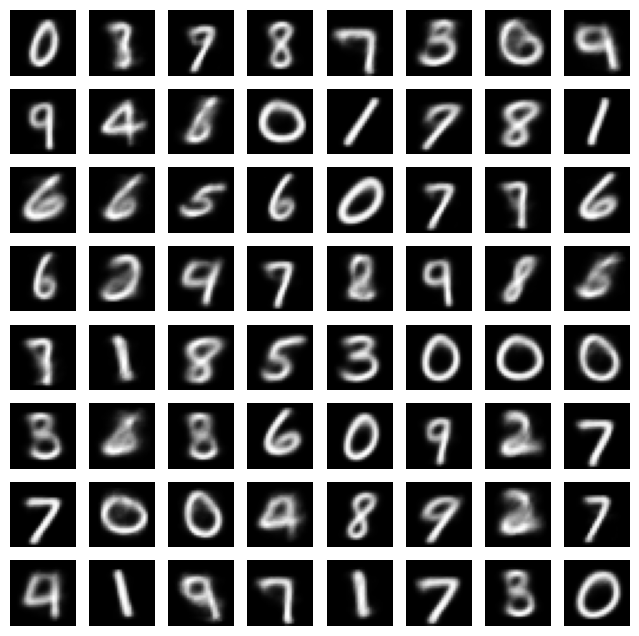

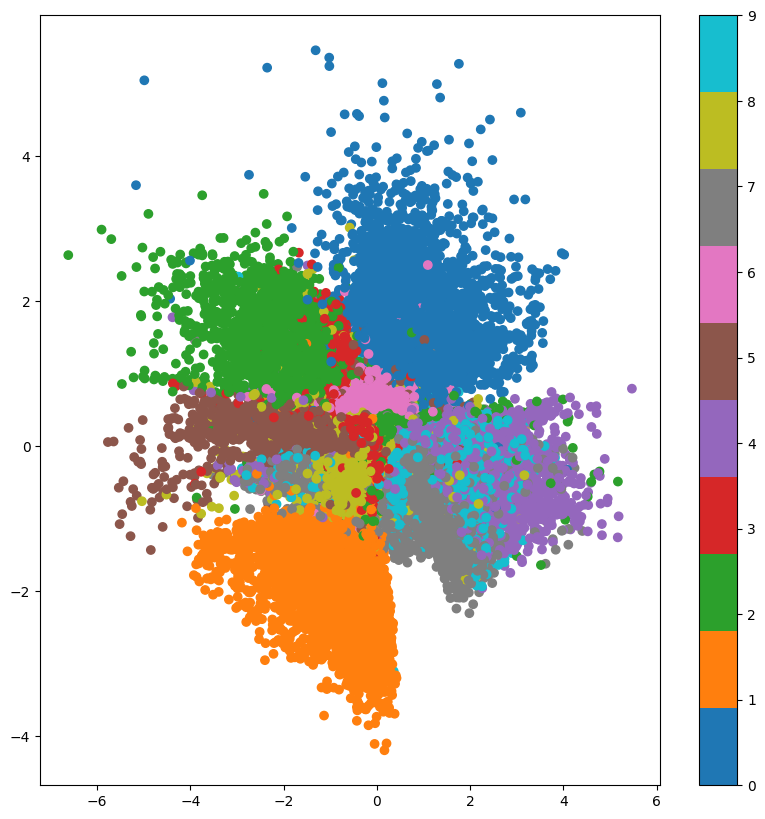

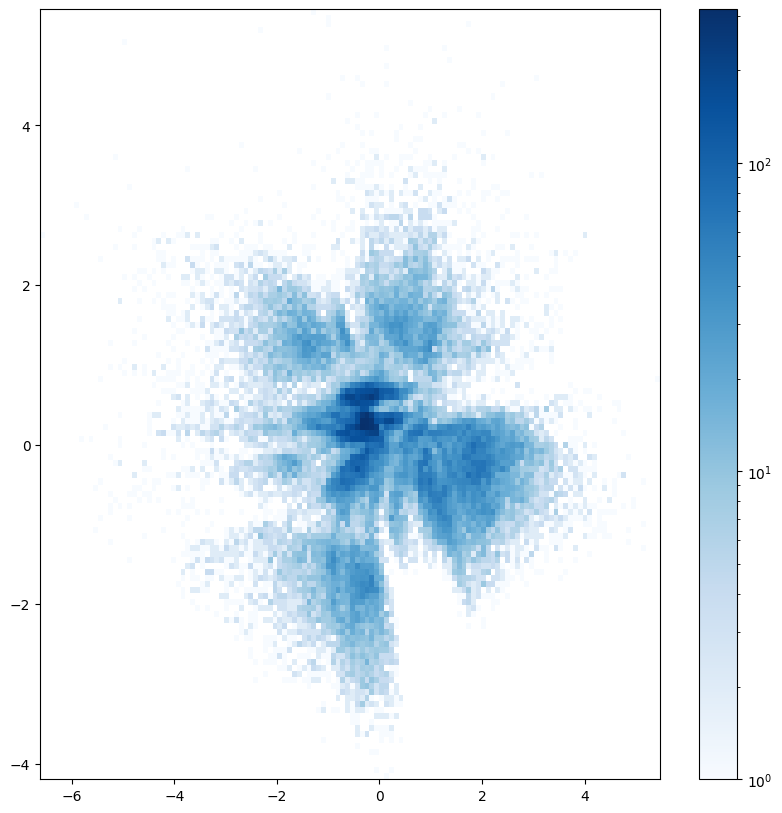

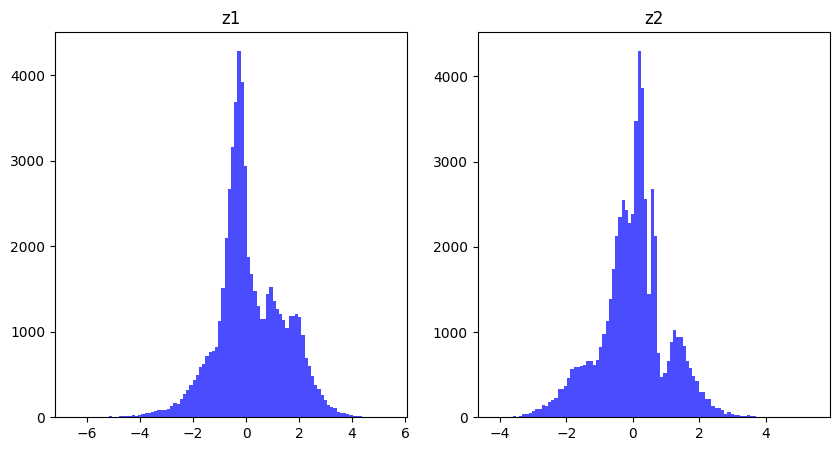

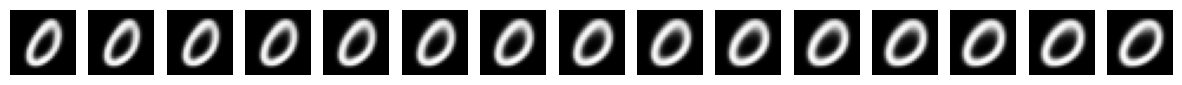

In [6]:
import matplotlib.pyplot as plt

z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(
            samples[i * 8 + j].view(28, 28).cpu().detach().numpy(), cmap="gray"
        )
        ax[i, j].axis("off")

# plt.show()
plt.savefig("vae_mnist.webp")

# encode and plot the z values for the train set
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc="Encoding"):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())
import numpy as np

z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap="tab10")
plt.colorbar()
# plt.show()
plt.savefig("vae_mnist_2d_scatter.webp")
# plot as 2d histogram, log scale
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 10))
plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap="Blues", norm=LogNorm())
plt.colorbar()
# plt.show()
plt.savefig("vae_mnist_2d_hist.webp")
# plot 1d histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z_all[:, 0], bins=100, color="b", alpha=0.7)
ax[0].set_title("z1")
ax[1].hist(z_all[:, 1], bins=100, color="b", alpha=0.7)
ax[1].set_title("z2")
# plt.show()
plt.savefig("vae_mnist_1d_hist.webp")
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap="gray")
    ax[i].axis("off")

plt.savefig("vae_mnist_interp.webp")